### Libraries

In [1]:
import cv2
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from zipfile import ZipFile
from io import BytesIO
from PIL import Image

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, ToTensor, Normalize
import torchvision.transforms as transforms
import torch.nn.functional as F

### DataLoader

In [2]:
train_higher_images = '/mnt/f/datasets/SR_training_datasets/DIV2K/DIV2K_train_HR.zip'
train_lower_images = '/mnt/f/datasets/SR_training_datasets/DIV2K/DIV2K_train_LR_bicubic_X4.zip'

valid_higher_images = '/mnt/f/datasets/SR_training_datasets/DIV2K/DIV2K_valid_HR.zip'
valid_lower_images = '/mnt/f/datasets/SR_training_datasets/DIV2K/DIV2K_valid_LR_bicubic_X4.zip'

In [3]:
def get_transform():
    return Compose([
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [4]:
class ZipDataset(Dataset):
    def __init__(self, zip_file_HR, zip_file_LR, transform=None):
        self.zip_file_HR = ZipFile(zip_file_HR)
        self.zip_file_LR = ZipFile(zip_file_LR)
        self.file_list_HR = self.zip_file_HR.namelist()
        self.file_list_HR = [file for file in self.file_list_HR if file.endswith(('.png', '.jpg', '.jpeg'))]
        self.file_list_LR = self.zip_file_LR.namelist()
        self.file_list_LR = [file for file in self.file_list_LR if file.endswith(('.png', '.jpg', '.jpeg'))]
        self.transform = get_transform()

        self.lr_mapping = {os.path.splitext(os.path.basename(name))[0].split('x')[0]: i for i, name in enumerate(self.file_list_LR)}

    def __len__(self):
        return len(self.file_list_HR)

    def __getitem__(self, idx):
        file_HR = self.file_list_HR[idx]
        # Get the base name of the HR image
        base_name_HR = os.path.splitext(os.path.basename(file_HR))[0]
        # Find the corresponding LR image
        idx_LR = self.lr_mapping[base_name_HR]
        file_LR = self.file_list_LR[idx_LR]
        
        # printing to check the image names are same or not
        
        # print(file_HR)
        # print(file_LR)

        with self.zip_file_HR.open(file_HR) as f:
            image_HR = Image.open(BytesIO(f.read()))
        with self.zip_file_LR.open(file_LR) as f:
            image_LR = Image.open(BytesIO(f.read()))
        if self.transform:
            image_HR = self.transform(image_HR)
            image_LR = self.transform(image_LR)

        return image_LR, image_HR

#### Creating datasets

In [5]:
train_dataset = ZipDataset(train_higher_images, train_lower_images)
valid_dataset = ZipDataset(valid_higher_images, valid_lower_images)

#### Creating dataloaders

In [6]:
def my_collate(batch):
    data = [item[0] for item in batch]
    target = [item[1] for item in batch]
    return [data, target]

In [7]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=my_collate)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False, collate_fn=my_collate)

#### Testing with images

In [8]:
# iterate over the dataloader
for i, (images, labels) in enumerate(train_loader):
    # print the shapes of the images and labels
    print(f'Batch {i+1}:')
    print('Images shape:', images[0].shape)
    print('Labels shape:', labels[0].shape)
    # break the loop after the first batch
    break

Batch 1:
Images shape: torch.Size([3, 303, 510])
Labels shape: torch.Size([3, 1212, 2040])


In [9]:
def show_tensor_as_image(tensor):
    # Select the first image from the batch
    # tensor = tensor[0]

    # Define the mean and std
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    # Unnormalize the tensor
    tensor = tensor * std + mean

    # Clamp the values in the tensor to the range [0, 1]
    tensor = torch.clamp(tensor, 0, 1)

    # Convert the tensor to a PIL Image and then convert it to a numpy array
    image = transforms.ToPILImage()(tensor).convert("RGB")
    plt.imshow(image)
    plt.show()


In [10]:
i = 5

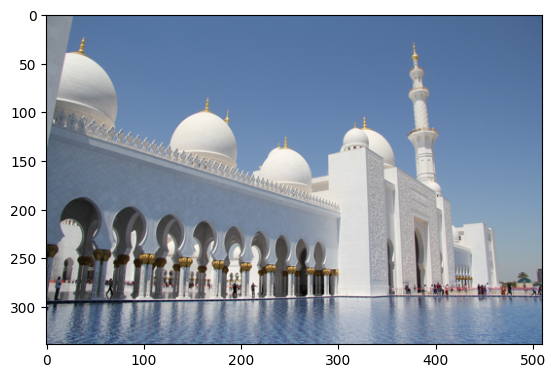

In [11]:
show_tensor_as_image(images[i])

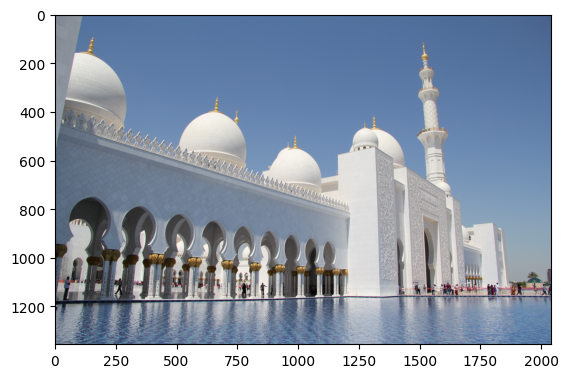

In [12]:
show_tensor_as_image(labels[i])

### Model with modules

#### RCAT module

In [13]:
class RCat(nn.Module):
    def __init__(self, f):
        super(RCat, self).__init__()
        self.conv1 = nn.Conv2d(f, f//4, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(f, 16, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(16, 16, kernel_size=1, stride=1, padding=0)
        self.conv4 = nn.Conv2d(16, 16, kernel_size=5, stride=1, padding=2)
        self.conv5 = nn.Conv2d(16, 16, kernel_size=7, stride=1, padding=3)
        self.conv6 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1)
        self.conv7 = nn.Conv2d(f//2, f//4, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        y1 = F.relu(self.conv1(x))
        x1 = F.relu(self.conv2(x))
        x1 = F.relu(self.conv3(x1))
        x1 = F.relu(self.conv4(x1))
        x1 = F.relu(self.conv5(x1))
        x1 = F.relu(self.conv6(x1))
        c1 = torch.cat((x1, y1), dim=1)
        c2 = F.relu(self.conv7(c1))
        return c2 + y1

#### RDN module

In [14]:
class RDN(nn.Module):
    def __init__(self, f):
        super(RDN, self).__init__()
        self.conv1 = nn.Conv2d(f, f, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(f, f, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(f, f, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(f, f, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(3*f, f//4, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        y1 = self.conv1(x)
        y2 = self.conv2(y1)
        a1 = y1 + y2
        y3 = self.conv3(a1)
        a2 = y3 + a1
        y4 = self.conv4(a2)
        a3 = a1 + a2 + y4
        c = torch.cat((a1, a2, a3), dim=1)
        return self.conv5(c)

#### RUNT module

In [15]:
class Runt(nn.Module):
    def __init__(self, f):
        super(Runt, self).__init__()
        self.conv1 = nn.Conv2d(f, f, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(f, f, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(f, f//2, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(f//2, f//2, kernel_size=5, padding=2)
        self.conv5 = nn.Conv2d(f//2, f//4, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(f//4, f//4, kernel_size=5, padding=2)
        self.conv7 = nn.Conv2d(f//4, f//8, kernel_size=3, padding=1)
        self.conv8 = nn.Conv2d(f//8, f//8, kernel_size=5, padding=2)
        self.conv9 = nn.Conv2d(f//8, f//8, kernel_size=1)
        self.conv10 = nn.Conv2d(f//4, f//4, kernel_size=1)
        self.conv11 = nn.Conv2d(f//2, f//2, kernel_size=1)
        self.conv12 = nn.Conv2d(f, f, kernel_size=1)
        self.conv13 = nn.Conv2d(f, 3, kernel_size=1)

    def forward(self, x):
        y1 = F.relu(self.conv1(x))
        y1 = F.relu(self.conv2(y1))
        y2 = F.relu(self.conv3(y1))
        y2 = F.relu(self.conv4(y2))
        y3 = F.relu(self.conv5(y2))
        y3 = F.relu(self.conv6(y3))
        y4 = F.relu(self.conv7(y3))
        y4 = F.relu(self.conv8(y4))
        y5 = F.relu(self.conv9(y4))
        c1 = torch.cat([y5, y4], dim=1)
        y6 = F.relu(self.conv10(c1))
        c2 = torch.cat([y6, y3], dim=1)
        y7 = F.relu(self.conv11(c2))
        c3 = torch.cat([y7, y2], dim=1)
        y8 = F.relu(self.conv12(c3))
        y8 = y8 + y1
        y9 = self.conv13(y8)
        return y9

#### DEN module

In [39]:
class Den(nn.Module):
    def __init__(self):
        super(Den, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=1)
        self.actc = ACTC()  # Assuming ACTC is a defined PyTorch module
        self.mdsr1 = MDSR1(32)  # Assuming MDSR1 is a defined PyTorch module
        self.rdn = RDN(128)  # Assuming RDN is a defined PyTorch module
        self.conv4 = nn.Conv2d(259, 3, kernel_size=3, padding=2, dilation=2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        f1 = self.actc(x)
        f2 = self.mdsr1(x)
        # f3 = self.rdn(x)
        # inp = torch.cat([f1, f2, f3, x], dim=1)
        # x = self.conv4(inp)
        return f2

#### ACTC module

In [17]:
class ACTC(nn.Module):
    def __init__(self):
        super(ACTC, self).__init__()
        self.conv1 = nn.Conv2d(64, 7, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 7, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(64, 7, kernel_size=7, padding=3)
        self.conv4 = nn.Conv2d(21, 3, kernel_size=3, padding=1)

    def forward(self, x):
        x1 = F.relu(x)
        x2 = torch.sigmoid(x)
        x3 = x2 * x
        x4 = F.softplus(x)
        x4 = torch.tanh(x4)
        x5 = x4 * x
        c1 = self.conv1(x1)
        c2 = self.conv2(x3)
        c3 = self.conv3(x5)
        cx = torch.cat([c1, c2, c3], dim=1)
        y = self.conv4(cx)
        return y

#### R1 module

In [18]:
class R1(nn.Module):
    def __init__(self, features):
        super(R1, self).__init__()
        self.conv1 = nn.Conv2d(features, features, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(features, features, kernel_size=3, padding=1)

    def forward(self, input_tensor):
        x = F.relu(self.conv1(input_tensor))
        x = self.conv2(x)
        return x + input_tensor

#### MDSR1 module

In [19]:
class MDSR1(nn.Module):
    def __init__(self, f):
        super(MDSR1, self).__init__()
        self.conv1 = nn.Conv2d(3, f, kernel_size=3, padding=1)
        self.r1 = R1(f)  # Assuming R1 is a defined PyTorch module
        self.conv2 = nn.Conv2d(4*f, 3, kernel_size=3, padding=1)

    def forward(self, ix):
        x = F.relu(self.conv1(ix))
        x1 = self.r1(x)
        x1 = self.r1(x1)
        x2 = self.r1(x)
        x2 = self.r1(x2)
        x3 = self.r1(x)
        x3 = self.r1(x3)
        x = x1 + x2 + x3
        x = torch.cat([x, x1, x2, x3], dim=1)
        x = self.conv2(x)
        return x

#### Created Custom Model

In [20]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=2, dilation=2)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1, padding=4, dilation=4)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=1, padding=16, dilation=16)
        self.adjust_channels = nn.Conv2d(64, 3, kernel_size=1) 
        self.den = Den()  # Assuming Den is a defined PyTorch module
        self.runt = Runt(16)  # Assuming Runt is a defined PyTorch module
        self.conv4 = nn.Conv2d(64, 3, kernel_size=1, padding=8, dilation=8)  # Adjusted number of input channels
        self.runt2 = Runt(32)  # Assuming Runt is a defined PyTorch module
        self.conv5 = nn.Conv2d(128, 3, kernel_size=1, padding=8, dilation=8)  # Adjusted number of input channels

    def forward(self, input_im):
        x = F.relu(self.conv1(input_im))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        # x1 = self.adjust_channels(x) 
        x1 = self.den(x)
        x2 = self.runt(x)
        x = torch.cat([x1, x2], dim=1)
        print(x.shape)
        x = F.relu(self.conv4(x))
        x = torch.cat([self.den(x), self.runt2(x)], dim=1)
        y = self.conv5(x)
        # Upsample the output to be 4 times the size of the input
        y = F.interpolate(y, scale_factor=4, mode='bilinear', align_corners=False)
        return y


# self.conv4 = nn.Conv2d(64, 3, kernel_size=1, padding=8, dilation=8)

#### Training part

In [21]:
# Instantiate the model
model = MyModel()

# Define a loss function
criterion = nn.MSELoss()

# Define an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Number of epochs
num_epochs = 10

# Move the model to GPU if available
if torch.cuda.is_available():
    model = model.cuda()

##### Training loop

In [22]:
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    for i, (inputs, targets) in enumerate(train_loader):
        # Process each input and target tensor individually
        for input1, target in zip(inputs, targets):
            # Move data to GPU if available
            if torch.cuda.is_available():
                input1 = input1.cuda()
                target = target.cuda()

            # Forward pass
            output = model(input1.unsqueeze(0))

            # Compute loss
            loss = criterion(output, target.unsqueeze(0))

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient computation
        for i, (inputs, targets) in enumerate(valid_loader):
            # Process each input and target tensor individually
            for input1, target in zip(inputs, targets):
                # Move data to GPU if available
                if torch.cuda.is_available():
                    input1 = input1.cuda()
                    target = target.cuda()

                # Forward pass
                output = model(input1.unsqueeze(0))

                # Compute loss
                loss = criterion(output, target.unsqueeze(0))

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')


RuntimeError: Given groups=1, weight of size [32, 3, 3, 3], expected input[1, 64, 379, 550] to have 3 channels, but got 64 channels instead

In [23]:
t = input1.unsqueeze(0)
t.shape

torch.Size([1, 3, 339, 510])

In [24]:
o = model(t)

RuntimeError: Given groups=1, weight of size [32, 3, 3, 3], expected input[1, 64, 379, 550] to have 3 channels, but got 64 channels instead

In [40]:
den = Den()

In [41]:
den = den.cuda()

In [42]:
p = den(t)

RuntimeError: Given groups=1, weight of size [32, 3, 3, 3], expected input[1, 64, 339, 510] to have 3 channels, but got 64 channels instead

In [37]:
mdr = MDSR1(32)
mdr = mdr.cuda()
p = mdr(p)

In [36]:
p.shape

torch.Size([1, 3, 339, 510])

In [38]:
rdn = RDN(128)
rdn = rdn.cuda()
p = rdn(p)

RuntimeError: Given groups=1, weight of size [128, 128, 3, 3], expected input[1, 3, 339, 510] to have 128 channels, but got 3 channels instead